# North Atlantic Basin

In [46]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [47]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b9d6e7a45148485aa19bf127b696ac20/status,


In [15]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import gsw
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [6]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_bih']*ds['drhodt']).rename('sst'),
                      (ds['SSS_bih']*ds['drhods']).rename('sss'),
                       ds['rho_bih'].rename('rho'),
                       ds['cabbeling']])
    return newds

In [7]:
tend = new_ds(tendencies)

In [8]:
tend

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 14965)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

# 1) Spatial map of NASTMW outcropping in each month

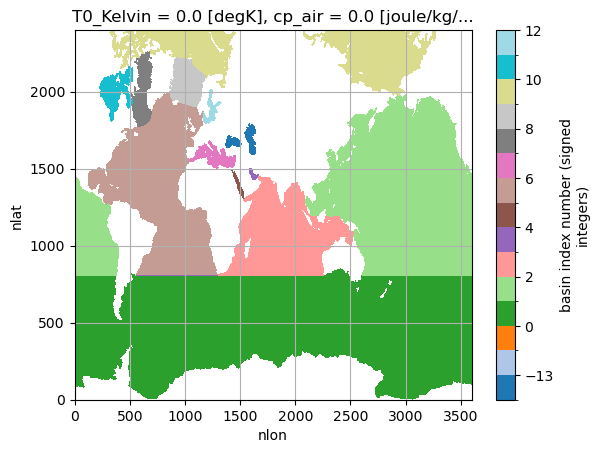

In [30]:
regions = np.unique(cesm.REGION_MASK)
cesm.REGION_MASK.where(cesm.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

In [9]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [10]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [11]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

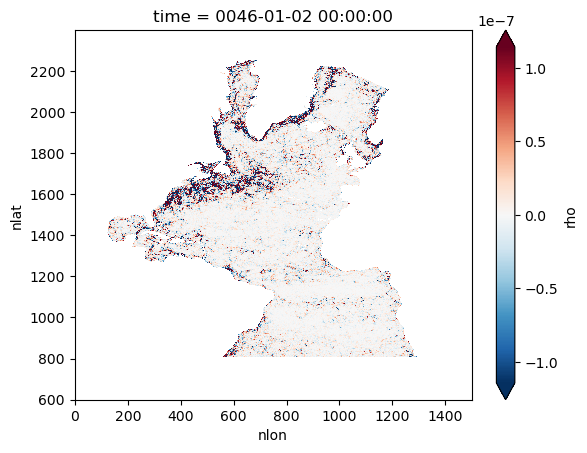

In [12]:
tend.rho.where(atl_mask).isel(time=0).isel(nlon=slice(0, 1500), nlat=slice(600, None)).plot(robust=True)

In [13]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))


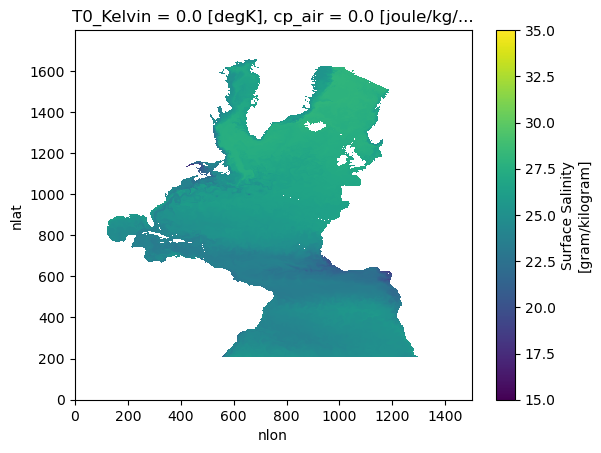

In [14]:
rho[0].where(atl_mask).isel(nlon=slice(0, 1500), nlat=slice(600, None)).plot(vmin=15, vmax=35)

In [15]:
rho_bins[115]

26.499999999999957

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))


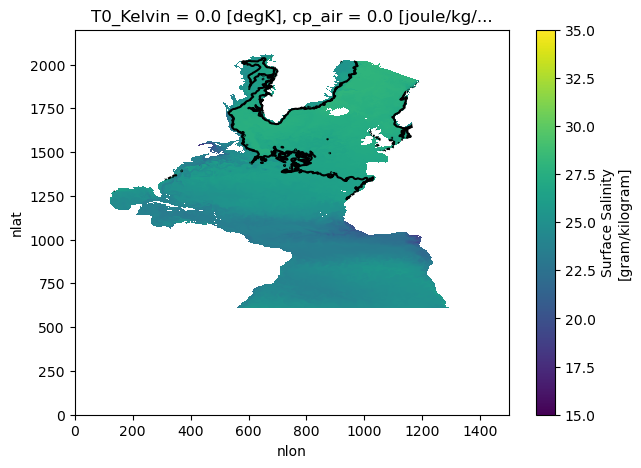

In [17]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(7,5))
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

rho[0].where(atl_mask).isel(**selection).plot(vmin=15, vmax=35, ax=ax)
C = rho[0].where(atl_mask).isel(**selection).plot.contour(colors='k', levels=[26.499999999999957], ax=ax)#, add_colorbar=True)
#C.collections[115].set_color('k')
#C.collections[115].set_linewidth(1.5);
#plt.clabel(C);

## Groupby $\rho$ and plot each month's contour map

In [18]:
rho_gb = rho.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

In [19]:
rho_gb

<xarray.DataArray 'rho' (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float64, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

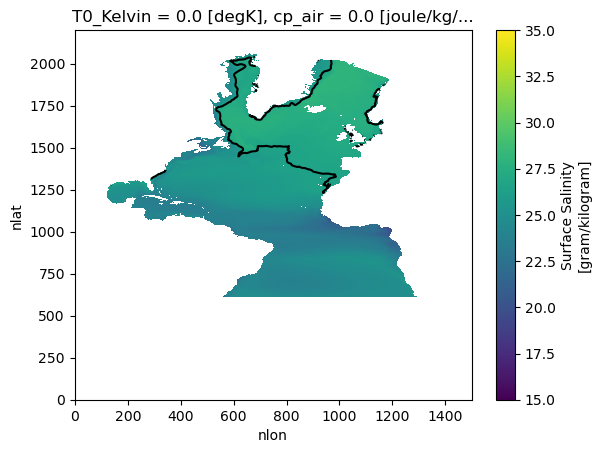

In [55]:
rho_gb[0].plot.contour(colors='k', levels=[rho_bins[115]])
rho_gb[0].plot(vmin=15, vmax=35)

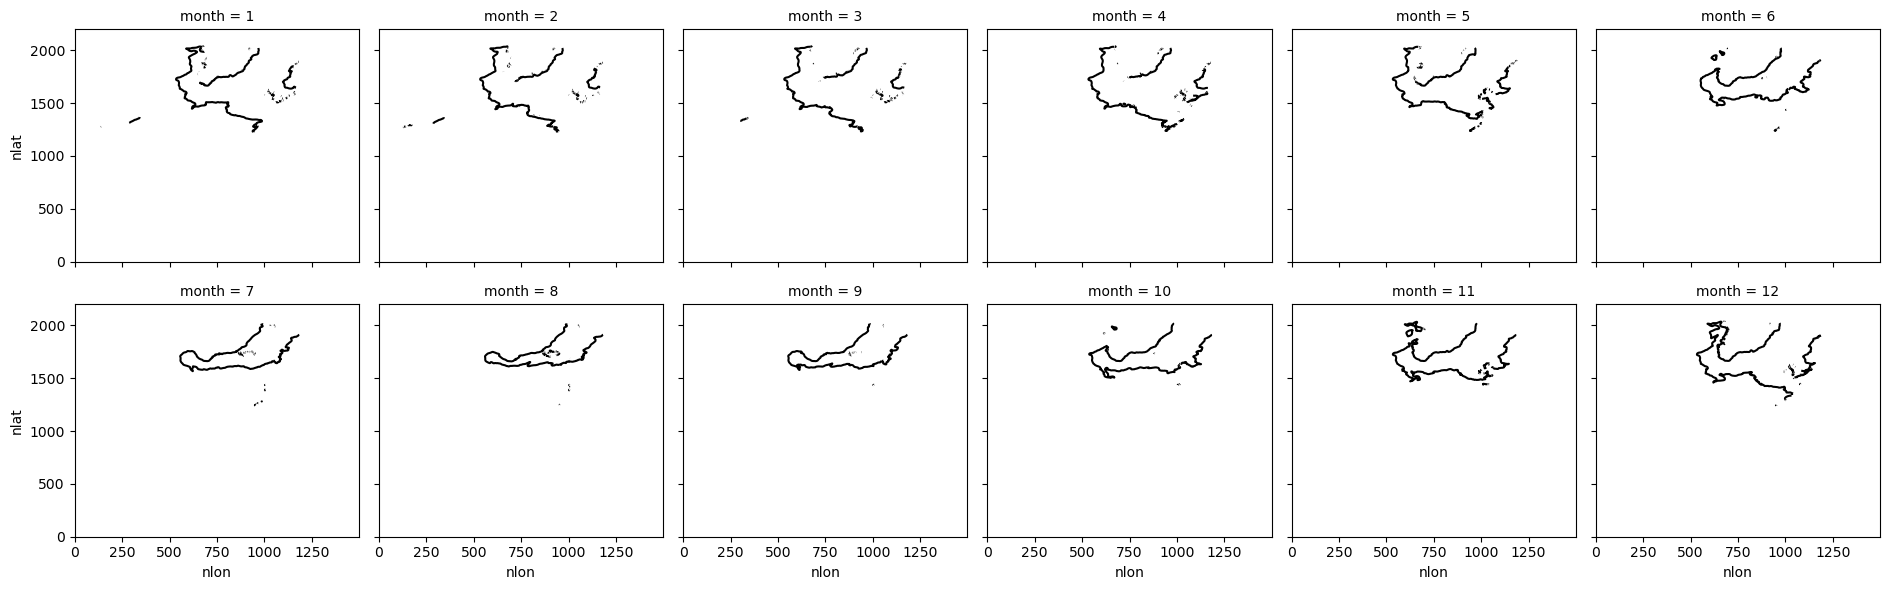

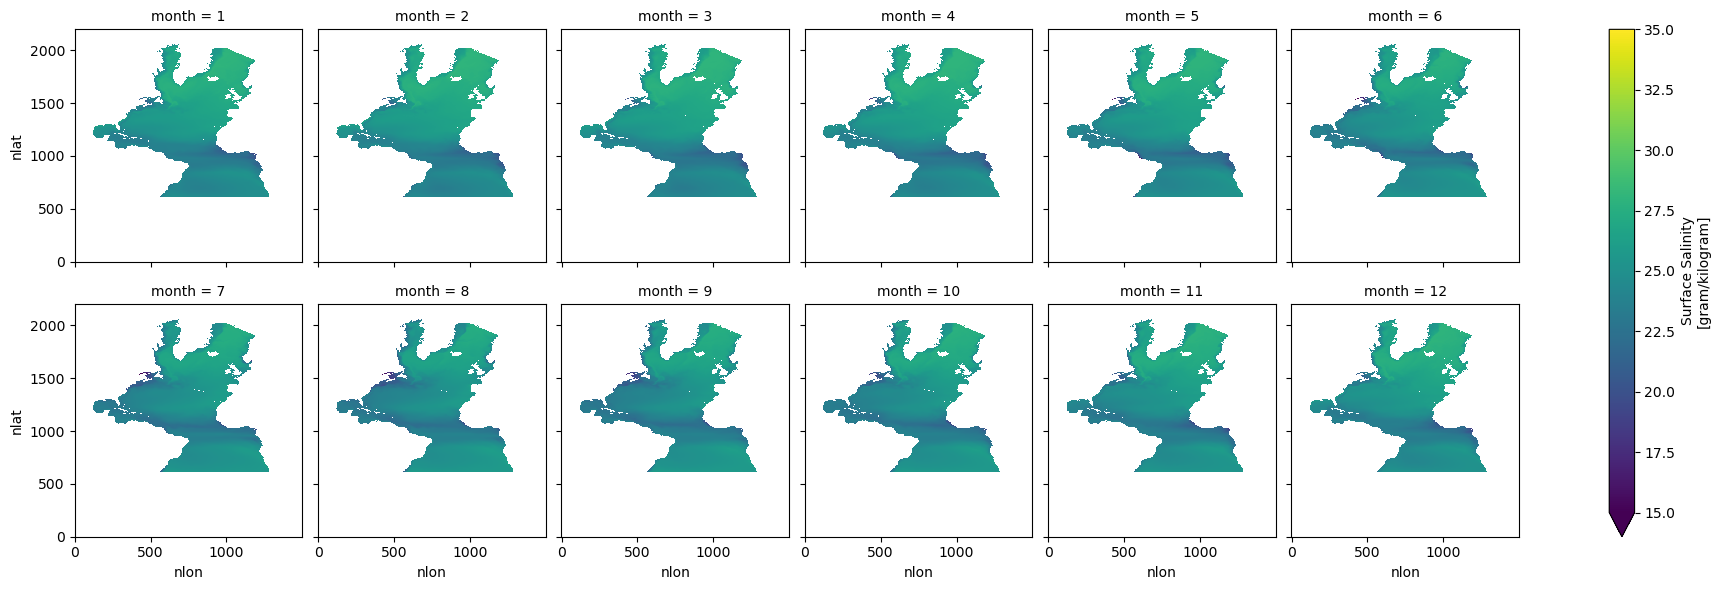

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._h

In [56]:
rho_gb.sel(month=rho_gb.month.values).plot.contour(col='month', col_wrap=6, colors='k', levels=[rho_bins[115]]);
rho_gb.sel(month=rho_gb.month.values).plot(col='month', col_wrap=6, vmin=15, vmax=35)

# Formation budget of NASTMW

In [20]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(path):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/'+
                                              path +'_histograms.zarr'))
    return ds
    
natl = xr.merge([open_ds('natl'), open_ds('surf_natl')])

In [21]:
nastmw = natl.sel(rho0_bin=1026.5, method='nearest')
nastmw

<xarray.Dataset>
Dimensions:               (time: 14965)
Coordinates:
    rho0_bin              float64 1.027e+03
  * time                  (time) object 0046-01-02 00:00:00 ... 0087-01-01 00...
Data variables:
    OMEGA_NATL_cabbeling  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_rho        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sss        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sst        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [22]:
nastmw_gb = nastmw.groupby('time.month').mean()

In [23]:
nastmw_gb

<xarray.Dataset>
Dimensions:               (month: 12)
Coordinates:
    rho0_bin              float64 1.027e+03
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OMEGA_NATL_cabbeling  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_rho        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sss        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sst        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [37]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.73701ab06c614560a4bb275b3795b348/status,


In [43]:
(nastmw_gb.OMEGA_NATL_rho + nastmw_gb.OMEGA_NATL_cabbeling - nastmw_gb.OMEGA_NATL_sst - nastmw_gb.OMEGA_NATL_sss)[0].values

array(0.00269222)

In [52]:
def ann_mean(ds, basin_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_mix=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    for (i,j) in zip(list(ds.data_vars)[:-2], line_mix): #slicing to mixing terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax0)
    for (i,j) in zip(list(ds.data_vars)[-2:], line_surf): #slicing to surf terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax1)
  
    ax0.legend()
    #ax0.set_xlim(1016,1030)
    ax0.set_ylabel(r'Transformation (Sv / $\Delta \sigma_0$)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    #ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Surface terms')
    ax1.set_xlabel('')
    
    fig.supxlabel('Month', fontsize=16)
    plt.suptitle('Monthly Mean Transformation', fontsize=20)
    plt.savefig(f'{basin_title}_mo_mean_hist_fig.pdf');

In [53]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b9d6e7a45148485aa19bf127b696ac20/status,


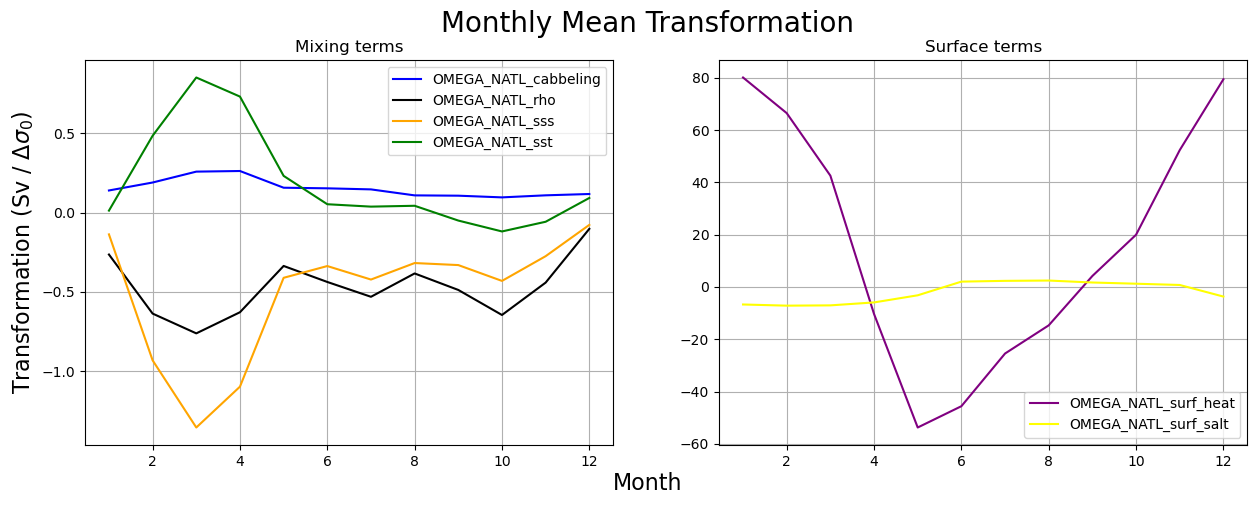

In [54]:
ann_mean(nastmw_gb, 'NATL')

In [55]:
client.close()
cluster.close()